In [ ]:
import transformers

token = transformers.AutoTokenizer.from_pretrained("gpt2")
print(token.shape())

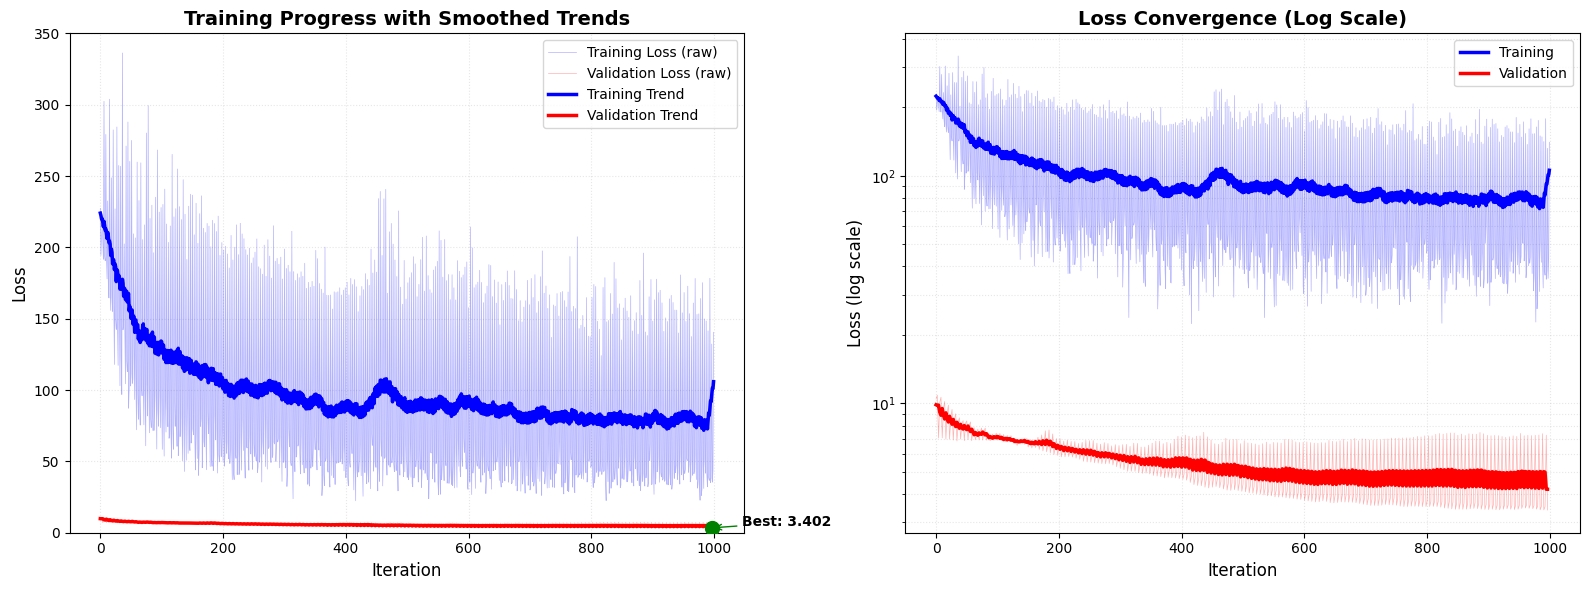

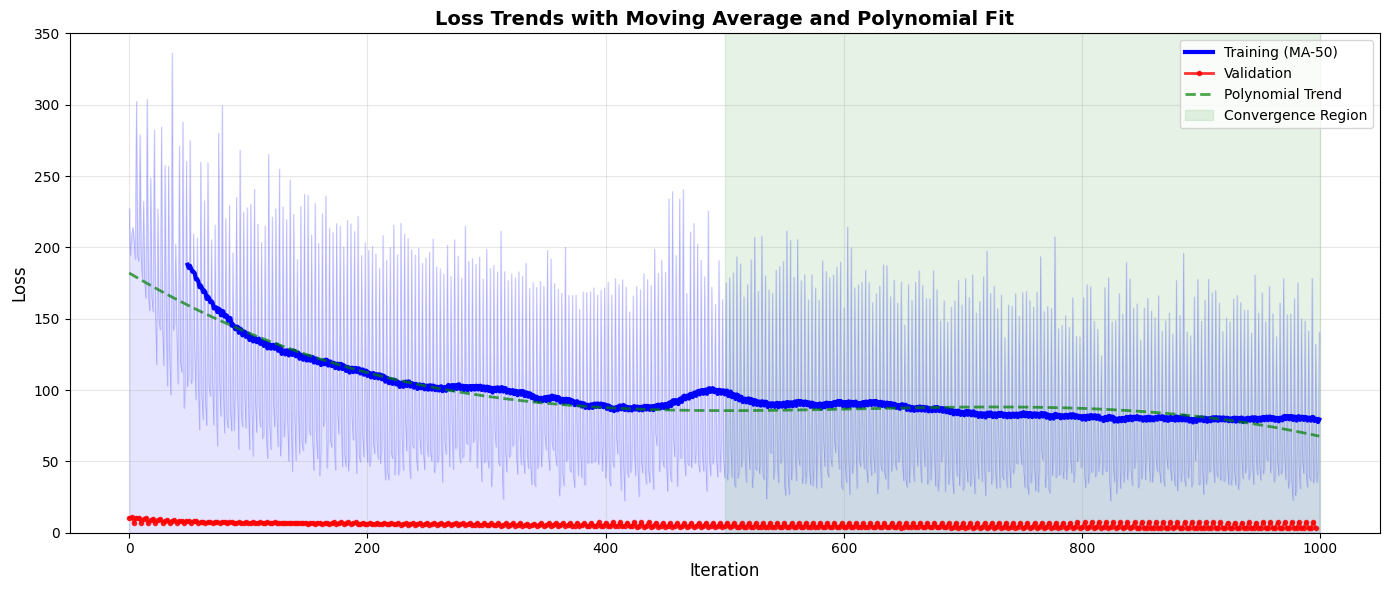

Initial Training Loss: 227.30
Final Training Loss: 140.47
Training Loss Reduction: 38.2%

Initial Validation Loss: 10.47
Final Validation Loss: 3.40
Best Validation Loss: 3.402 at iteration 996
Validation Loss Reduction: 67.5%


In [25]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d
%matplotlib inline

# Load data
with open('part1_switchable_precision/training_stats.json','r') as f:
    data = json.load(f)

iteration_losses = data['iteration_losses']
validation_losses = data['validation_losses']

# Create proper x-axes
iterations = np.arange(len(iteration_losses))
# Validation is measured every few iterations
val_frequency = len(iteration_losses) // len(validation_losses)
val_iterations = np.arange(0, len(iteration_losses), val_frequency)[:len(validation_losses)]

# Create figure with better size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ========== Plot 1: Raw data with trend lines ==========
# Plot raw data with transparency
ax1.plot(iterations, iteration_losses, 'b-', alpha=0.3, linewidth=0.5, label='Training Loss (raw)')      
ax1.plot(val_iterations, validation_losses, 'r-', alpha=0.3, linewidth=0.5, label='Validation Loss (raw)')

# Add smoothed trend lines
window_size = 20  # Smooth over 20 iterations
if len(iteration_losses) > window_size:
    train_smooth = uniform_filter1d(iteration_losses, size=window_size, mode='nearest')
    ax1.plot(iterations, train_smooth, 'b-', linewidth=2.5, label='Training Trend')

if len(validation_losses) > 5:
    val_smooth = uniform_filter1d(validation_losses, size=5, mode='nearest')
    ax1.plot(val_iterations, val_smooth, 'r-', linewidth=2.5, label='Validation Trend')

# Mark best validation loss
best_val_idx = np.argmin(validation_losses)
best_val_loss = validation_losses[best_val_idx]
ax1.scatter(val_iterations[best_val_idx], best_val_loss, color='green', s=100, zorder=5)
ax1.annotate(f'Best: {best_val_loss:.3f}',
            xy=(val_iterations[best_val_idx], best_val_loss),
            xytext=(val_iterations[best_val_idx]+50, best_val_loss+1),
            arrowprops=dict(arrowstyle='->', color='green'),
            fontsize=10, fontweight='bold')

ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Progress with Smoothed Trends', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3, linestyle=':')
ax1.set_ylim(bottom=0, top=min(350, max(max(iteration_losses), max(validation_losses))*1.1))

# ========== Plot 2: Log scale to see convergence better ==========
ax2.semilogy(iterations, iteration_losses, 'b-', alpha=0.3, linewidth=0.5)
ax2.semilogy(val_iterations, validation_losses, 'r-', alpha=0.3, linewidth=0.5)

# Add smoothed lines on log scale
if len(iteration_losses) > window_size:
    ax2.semilogy(iterations, train_smooth, 'b-', linewidth=2.5, label='Training')
if len(validation_losses) > 5:
    ax2.semilogy(val_iterations, val_smooth, 'r-', linewidth=2.5, label='Validation')

ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Loss (log scale)', fontsize=12)
ax2.set_title('Loss Convergence (Log Scale)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both', linestyle=':')

plt.tight_layout()
plt.show()

# ========== Additional trend analysis plot ==========
fig2, ax3 = plt.subplots(figsize=(14, 6))

# Use moving average for clearer trends
window = 50
train_ma = np.convolve(iteration_losses, np.ones(window)/window, mode='valid')
iterations_ma = iterations[window-1:]

# Plot with filled areas
ax3.fill_between(iterations, 0, iteration_losses, alpha=0.1, color='blue')
ax3.plot(iterations, iteration_losses, 'b-', alpha=0.2, linewidth=0.5)
ax3.plot(iterations_ma, train_ma, 'b-', linewidth=3, label=f'Training (MA-{window})')
ax3.plot(val_iterations, validation_losses, 'r-', linewidth=2, marker='o',
        markersize=3, label='Validation', alpha=0.8)

# Add trend line using polynomial fit
z = np.polyfit(iterations, iteration_losses, 3)  # 3rd degree polynomial
p = np.poly1d(z)
ax3.plot(iterations, p(iterations), 'g--', linewidth=2, alpha=0.7, label='Polynomial Trend')

# Highlight convergence region
if len(iteration_losses) > 500:
    ax3.axvspan(500, len(iteration_losses), alpha=0.1, color='green', label='Convergence Region')        

ax3.set_xlabel('Iteration', fontsize=12)
ax3.set_ylabel('Loss', fontsize=12)
ax3.set_title('Loss Trends with Moving Average and Polynomial Fit', fontsize=14, fontweight='bold')      
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(bottom=0, top=350)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Initial Training Loss: {iteration_losses[0]:.2f}")
print(f"Final Training Loss: {iteration_losses[-1]:.2f}")
print(f"Training Loss Reduction: {(1 - iteration_losses[-1]/iteration_losses[0])*100:.1f}%")
print(f"\nInitial Validation Loss: {validation_losses[0]:.2f}")
print(f"Final Validation Loss: {validation_losses[-1]:.2f}")
print(f"Best Validation Loss: {best_val_loss:.3f} at iteration {val_iterations[best_val_idx]}")
print(f"Validation Loss Reduction: {(1 - best_val_loss/validation_losses[0])*100:.1f}%")